# This notebook is illustrating how to use XCast for 2 dimension data using a csv file.
Created by Nachiketa Acharya on Oct,2023

## Import packages

In [1]:
import numpy as np
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import xcast as xc
import matplotlib.pyplot as plt 

print('XCAST VERSION: ', xc.__version__)

XCAST VERSION:  0.6.10


## Read CSV file and covert them to xarray

In [2]:
data = np.genfromtxt('exc3sprec.csv', delimiter=',', dtype='str')
x = data[1:,:-1].astype(float)
y = data[1:,-1].astype(float).squeeze().reshape(-1,1)


## Ensemble Mean

In [3]:
indices = np.arange(x.shape[0])
xval_preds, xval_y = [], []
preds_EM = x.mean(axis=-1).reshape(-1,1) 

## Multiple Linear Regression

In [4]:
from xcast.flat_estimators.mlr import linear_regression
indices = np.arange(x.shape[0])
xval_preds, xval_y = [], []
kf = KFold(n_splits=24)
for trainndx, testndx in kf.split(indices):
    xtrain, ytrain = x[trainndx, :], y[trainndx, 0].reshape(-1,1)
    xtest, ytest = x[testndx, :], y[testndx, 0].reshape(-1,1)
    xval_y.append(ytest)
    #net = xc.extreme_learning_machine(**elm_kwargs )
    mlr = linear_regression()
    #net = xc.MLR#for EPO-ELM
    mlr.fit(xtrain, ytrain)
    preds = mlr.predict(xtest)
    xval_preds.append(preds)
    
preds_mlr = np.vstack(xval_preds)
true = np.vstack(xval_y)

## Extreme Learning Machine 

### Define hyperparameter

In [5]:
elm_kwargs = {
            'regularization': 10,
            'hidden_layer_size': 10,#5
            'activation': 'relu',#, 'sigm', 'tanh', 'lin', 'leaky', 'relu', 'softplus'],
            'preprocessing':'minmax',# 'preprocessing': ['minmax', 'std', 'none' ],
            #'encoding': 'nonexceedance',#'encoding': [  'nonexceedance', 'binary'],
            #'quantiles': [1/3,2/3], #[0.0001, 0.5, 0.9999], [0.2, 0.4, 0.6, 0.8], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] ],
            #'standardize_y': True,#'standardize_y': [True, False],
            'n_estimators': 100,#30
            #'initialization':'normal'# ['uniform', 'normal', 'xavier']
}
    

### Run fitting

In [6]:
indices = np.arange(x.shape[0])
xval_preds, xval_y = [], []
kf = KFold(n_splits=24)
for trainndx, testndx in kf.split(indices):
    xtrain, ytrain = x[trainndx, :], y[trainndx, 0].reshape(-1,1)
    xtest, ytest = x[testndx, :], y[testndx, 0].reshape(-1,1)
    xval_y.append(ytest)
    net = xc.extreme_learning_machine(**elm_kwargs )
    #net = xc.epoelm(**epoelm_kwargs)#for EPO-ELM
    net.fit(xtrain, ytrain)
    preds = net.predict(xtest)
    xval_preds.append(preds)
    preds_ELM = np.vstack(xval_preds)


preds_ELM = np.vstack(xval_preds)
true = np.vstack(xval_y)

# Calculate skill metircs

In [7]:
from xcast.verification import normalized_centered_root_mean_squared_error


print('CC-EM: ',pearsonr(preds_EM.squeeze(),  true.squeeze() ))
print('IOA-EM: ', xc.index_of_agreement(preds_EM, true))
print('KGE-EM: ', xc.kling_gupta_efficiency(preds_EM, true))
print('NCRMSE-EM: ', normalized_centered_root_mean_squared_error(preds_EM, true))




print('CC-MLR: ',pearsonr(preds_mlr.squeeze(),  true.squeeze() ))
print('IOA-MLR: ', xc.index_of_agreement(preds_mlr, true))
print('KGE-MLR: ', xc.kling_gupta_efficiency(preds_mlr, true))
print('NCRMSE-MLR: ', normalized_centered_root_mean_squared_error(preds_mlr, true))



preds_ELM
print('CC-ELM: ',pearsonr(preds_ELM.squeeze(),  true.squeeze() ))
print('IOA-ELM: ', xc.index_of_agreement(preds_ELM, true))
print('KGE-ELM: ', xc.kling_gupta_efficiency(preds_ELM, true))
print('NCRMSE-ELM: ', normalized_centered_root_mean_squared_error(preds_ELM, true))



CC-EM:  PearsonRResult(statistic=0.13583317931110542, pvalue=0.5268224589481857)
IOA-EM:  0.15382402539379536
KGE-EM:  -0.3173514514733906
NCRMSE-EM:  0.1466146265727785
CC-MLR:  PearsonRResult(statistic=-0.29992243210248126, pvalue=0.15447480479136372)
IOA-MLR:  0.12530064222899062
KGE-MLR:  -0.5214796416249505
NCRMSE-MLR:  0.2755909374470408
CC-ELM:  PearsonRResult(statistic=0.3753146980484246, pvalue=0.07072680010749244)
IOA-ELM:  0.6211824099639192
KGE-ELM:  0.3456945681040344
NCRMSE-ELM:  0.15472673437194026


## line plot

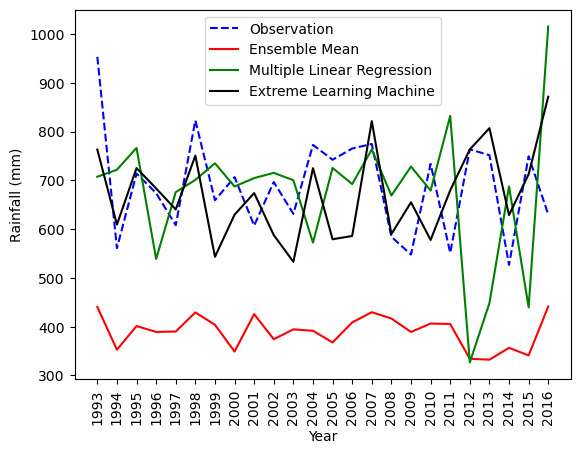

In [8]:
fig, ax = plt.subplots()
ax.set_ylabel('Rainfall (mm)')
ax.set_xlabel('Year')
t= ax.set_xticks(ticks=range(24), labels=[str(i) for i in range(1993, 2017) ], rotation=90)
plt.plot(true.squeeze(),'b--',label='Observation')
plt.plot(preds_EM,'r',label='Ensemble Mean')
plt.plot(preds_mlr,'g',label='Multiple Linear Regression')
plt.plot(preds_ELM,'k',label='Extreme Learning Machine')
plt.legend()